# Transformer model for Time Series Prediction

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt

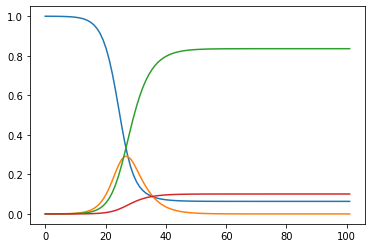

<Figure size 720x720 with 0 Axes>

In [6]:
%run data_simulator_corona.ipynb

In [7]:
theta = dic['theta']

In [8]:
test_torch_layer = nn.Linear(10,512)
test_tf_layer = tf.keras.layers.Dense(512)
test_torch_randint = torch.randn(64,10,10)
test_tf_randint = tf.random.uniform([64,16,10],0,10)
test_tf_layer(test_tf_randint).shape

TensorShape([64, 16, 512])

## Setup input pipeline

In [9]:
BATCH_SIZE = 64

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [11]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 3, 512)


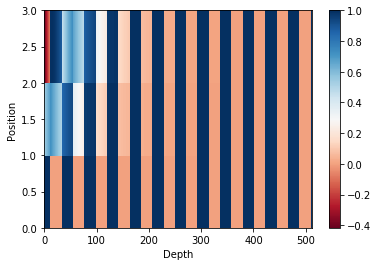

In [12]:
pos_encoding = positional_encoding(3, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [13]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [14]:
#x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
#print(x[0].shape)
#create_padding_mask(x[0])

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [15]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [17]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

      # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

      # softmax is normalized on the last axis (seq_len_k) so that the scores
      # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [18]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [19]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [22]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [23]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [24]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, attn_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weights

In [28]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output[0].shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [45]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output[0], 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [58]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        # adding embedding and position encoding
        #print("before embedding:",x.shape)
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        #print('after embedding:',x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #print('Encoder:',x.shape)
        #print(self.pos_encoding[:, :seq_len, :].shape)
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1 = self.enc_layers[i](x, training, mask)
            
            attention_weights['encoder_layer{}'.format(i+1)] = block1
            
        return x, attention_weights  # (batch_size, input_seq_len, d_model)

In [59]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62,1), dtype=tf.float32, minval=0, maxval=200)

sample_encoder_output,_ = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [60]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #print('Decoder:',x.shape)
        #print(self.pos_encoding[:, :seq_len, :].shape)
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [61]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26,1), dtype=tf.float32, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [62]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                            pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(1)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output,encoder_weights = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #print(tar.shape)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        #print(dec_output.shape)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, dimension_target)
        #print(final_output.shape)
        return final_output,attention_weights, encoder_weights

In [63]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,  
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 40,1), dtype=tf.float32, minval=0, maxval=100)
temp_target = tf.random.uniform((64,4,1), dtype=tf.float32, minval=0, maxval=100)

fn_out, _,_ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 4, 1])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [64]:
d_model = 128

In [65]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)) / 10

In [66]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [67]:
optimizer._decayed_lr(tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

Text(0.5, 0, 'Train Step')

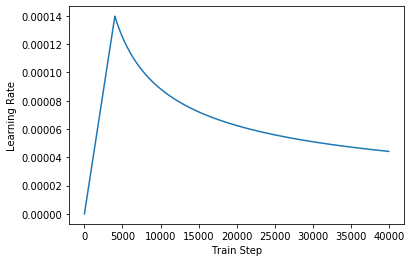

In [68]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [69]:
loss_object = tf.keras.losses.MSE

In [70]:
def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #print(real[0],np.argmax(pred[0],axis = 1))
    loss_ = loss_object(real, pred)
    #print(loss_)
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #print(tf.reduce_sum(loss_))
    return tf.reduce_sum(loss_) #/tf.reduce_sum(mask)

In [71]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [72]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 8

pe_input = 103 # input sequence length + start and end-token
pe_target = 4  # output sequence length (Parameter) + start or end-token
dropout_rate = 0.1

In [75]:
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          pe_input, 
                          pe_target,
                          rate=dropout_rate)

In [51]:
def create_masks(tar):
    # Encoder padding mask
    #enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    #dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    #dec_target_padding_mask = create_padding_mask(tar)
    #combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return look_ahead_mask

In [76]:
## padding maske ist auskommentiert wegen konstanter Sequenzlänge

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
#if ckpt_manager.latest_checkpoint:
 #   ckpt.restore(ckpt_manager.latest_checkpoint)
  #  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

## Data Generation

In [1294]:
x_train = []
y_train = []
for i in range(100):
    dic = data_generator(64,t_obs= 100,to_tensor= True)
    theta = dic['theta']
    x     = dic['x']
    x_train.append(x[:,:,:])
    y_train.append(theta[:,:])

"for i in range(100):\n    dic = data_generator(64,t_obs= 100,to_tensor= True)\n    theta = dic['theta']\n    x     = dic['x']\n    x_train.append(x[:,:,:])\n    y_train.append(theta[:,:])\n"

In [73]:
x = np.array(x_train)
x = np.insert(x,0,-1,axis = 2)   #initializing start token
x = np.insert(x,102,-2,axis = 2) #initializing end token

y = np.array(y_train)
y = np.insert(y,0,-1,axis = 2) #initializing start token
y = np.insert(y,4,-2,axis = 2) #initializing end token
y = np.expand_dims(y,-1)
print(x.shape)
print(y.shape)

#time_example = np.linspace(0,x[0].shape[0],x[0].shape[0])

#plt.plot(time_example,x[0,:,0])
#plt.figure(figsize=(10,10))
#plt.show()

(100, 64, 103, 4)
(100, 64, 5, 1)


In [74]:
#y = np.expand_dims(y,axis = 3)
x = tf.convert_to_tensor(x,dtype=tf.float32)
y = tf.convert_to_tensor(y,dtype=tf.float32)
x_train = x
y_train = y
#x_test = x[-10:,:,:,:]
#y_test = y[-10:,:,:,:]
print(x_train.shape)#,x_test.shape)
print(y_train.shape)#,y_test.shape)

(100, 64, 103, 4)
(100, 64, 5, 1)


## Training

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    #print(inp.shape,tar.shape)
    tar_inp = tar[:, :-1,:]
    tar_real = tar[:, 1:,:]
    #print(inp.shape,tar_inp.shape,tar_real.shape)
    lookahead_mask = create_masks(tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _,_ = transformer(inp, tar_inp, 
                                 True, 
                                 None, 
                                 lookahead_mask, 
                                 None)
        #print(tar_real,predictions)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    lr = optimizer._decayed_lr(tf.float32)
    train_loss(loss)
    #print(tf.squeeze(predictions).shape)
    train_accuracy(tar_real, predictions)
    return lr

In [ ]:
EPOCHS = 1

In [ ]:
transformer.load_weights('./checkpoints/Corona_DenseLayers_18.04.') ##load_weights of the transformer

In [1296]:
lr_array = []
loss_array = []


for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(zip(x_train,y_train)):
        #print(inp.shape,tar.shape)
        lr = train_step(inp, tar)
        #print(batch,inp.shape,tar.shape)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(),train_accuracy.result()))
            lr_array.append(lr)
            loss_array.append(train_loss.result())
            
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(),train_accuracy.result()))
    
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Loss 0.0000 Accuracy 0.0000
Time taken for 1 epoch: 0.020943880081176758 secs



In [1055]:
loss_save2 = loss_array
lr_save2 = lr_array

In [1057]:
lr_save.extend(lr_save2)

In [1058]:
loss_save_new.extend(loss_save2)

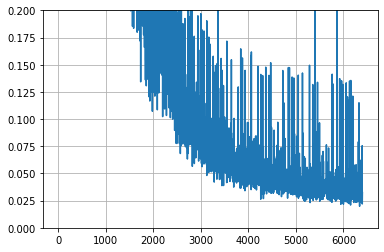

In [1301]:
epochs = np.linspace(0,len(loss_save_new),len(loss_save_new))
plt.plot(epochs,np.array(loss_save_new))
plt.ylim(0,0.2)
plt.grid(True)
#plt.savefig('Loss_curve_corona_18.04_0_0.2.png')
plt.show()

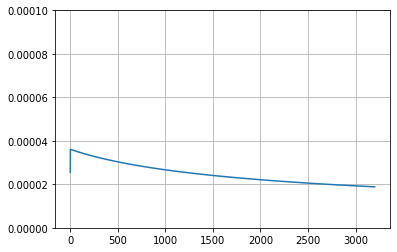

In [1062]:
epochs = np.linspace(0,len(lr_save),len(lr_save))
plt.plot(epochs,np.array(lr_save))
plt.ylim(0,0.0001)
plt.grid(True)
#plt.savefig('Loss_curve_corona_18.04_0_10.png')
plt.show()

In [1063]:
from numpy import savetxt
savetxt('loss_curve_corona_18.04.',loss_save_new,delimiter = ',')

In [131]:
import csv

with open('loss_curve_corona_18.04.', newline='') as csvfile:
    data = list(csv.reader(csvfile))

loss_save = data

In [1065]:
#transformer.save_weights('./checkpoints/Corona_DenseLayers_18.04.')

In [625]:
transformer.load_weights('./checkpoints/Corona_DenseLayers_18.04.')

## Evaluate

The following steps are used for evaluation:


* The `decoder` outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last prediction and concatentate the predicted parameter to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next parameters based on the previous parameters it predicted.

In [1108]:
def evaluate(inp_sentence):
    end_token = inp_sentence[:,-1,0][0]
    encoder_input = inp_sentence
    decoder_input = inp_sentence[:,0,0]
    output = tf.expand_dims(decoder_input,0)
    output = tf.expand_dims(output,-1)
    lookahead_mask = create_masks(output)
    for i in range(encoder_input.shape[1]):
        predictions, attention_weights, encoder_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 None,
                                                 lookahead_mask,
                                                 None)
        # select the last word from the seq_len dimension
        predictions = tf.squeeze(predictions,[2])

        if i == 3:
            return tf.concat([output, tf.expand_dims(predictions,-1)[:,-1:,:]], 1), attention_weights,encoder_weights
        
        output = tf.concat([output, tf.expand_dims(predictions,-1)[:,-1:,:]], 1)

    return tf.squeeze(output, axis=0)[1:], attention_weights, encoder_weights

In [1109]:
dic_eval = data_generator(1,t_obs= 100,to_tensor= True)
theta_eval = dic_eval['theta']
x_eval = dic_eval['x']
x_test = np.array(x_eval)
x_test = np.insert(x_test,0,-1,axis = 1)
x_test = np.insert(x_test,102,-2,axis = 1)

y_test = np.array(theta_eval)
y_test = np.insert(y_test,0,-1,axis = 1)
y_test = np.insert(y_test,4,-2,axis = 1)
y_test = np.expand_dims(y_test,-1)

print(x_test.shape,y_test.shape)

(1, 103, 4) (1, 5, 1)


In [1110]:
y_test

array([[[-1.        ],
        [ 0.17945778],
        [ 0.1265383 ],
        [ 0.13264145],
        [-2.        ]]], dtype=float32)

In [1111]:
pred,attention,encoder_weights = evaluate(x_test)
pred

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[-1.        ],
        [ 0.18142156],
        [ 0.12501238],
        [ 0.14079969],
        [-2.0901406 ]]], dtype=float32)>

In [1070]:
mean_dev_ = []
mean_rel_dev = []

for i in range(1000):
    dic_eval = data_generator(1,t_obs= 100,to_tensor= True)
    theta_eval = dic_eval['theta']
    x_eval = dic_eval['x']
    x_test = np.array(x_eval)
    x_test = np.insert(x_test,0,-1,axis = 1)
    x_test = np.insert(x_test,102,-2,axis = 1)
    y_test = np.array(theta_eval)
    y_test = np.insert(y_test,0,-1,axis = 1)
    y_test = np.insert(y_test,4,-2,axis = 1)
    y_test = np.expand_dims(y_test,-1)
    
    pred,_,_ = evaluate(x_test)
    mean_dev = np.sum(np.abs(y_test[0,1:-1,:] - pred[0,1:-1,:])) / len(y_test[0,1:-1,:])
    rel_dev_percent  = (np.sum(np.abs(y_test[0,1:-1,:] - pred[0,1:-1,:]) / np.abs(y_test[0,1:-1,:])) / len(y_test[0,1:-1,:])) * 100
    #print(mean_dev)
    #print(rel_dev_percent)
    mean_dev_.append(mean_dev)
    mean_rel_dev.append(rel_dev_percent)

In [1285]:
print('mittlere Abweichung: ',np.mean(np.array(mean_dev)))
print('relativer Fehler:    ',np.mean(np.array(mean_rel_dev)))

mittlere Abweichung:  0.004058018326759338
relativer Fehler:     10.584120667353272


In [1072]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    attention = tf.squeeze(attention[layer], axis=0)
    #print(attention.shape)
    dim_attention = attention.shape[1]
    #print(sentence,result)
    #print(sentence.shape,result.shape)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # plot the attention weights
        ax.matshow(attention[head][:, :], cmap='viridis')
        ax.yaxis_inverted()
        fontdict = {'fontsize': 10}

        #ax.set_xticks(range(attention.shape[2]))
        #ax.set_yticks(range(len(result)))

        ax.set_ylim(0, dim_attention - 1)

        #ax.set_xticklabels('{}'.format(sentence),fontdict = fontdict, rotation=90)

        #ax.set_yticklabels('{}'.format(result),fontdict = fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    
    plt.show()

In [1073]:
def translate(sentence, plot_decoder='',plot_encoder = ''):
    result, attention_weights,encoder_weights = evaluate(sentence)
  
    if plot_decoder:
        plot_attention_weights(attention_weights, sentence, result, plot_decoder)
        
    if plot_encoder:
        plot_attention_weights(encoder_weights,sentence,result,plot_encoder)
    return result

In [1074]:
translate(x_test)

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[-1.        ],
        [ 1.3228816 ],
        [ 0.37219262],
        [ 0.17691334],
        [-2.0901866 ]]], dtype=float32)>

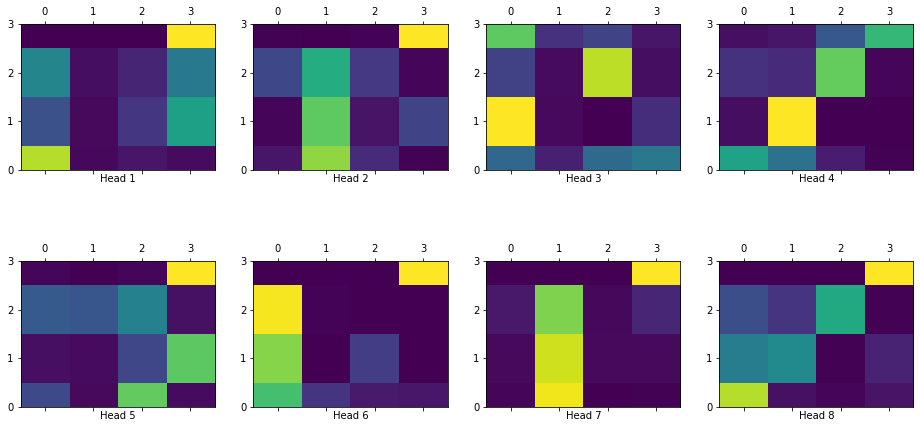

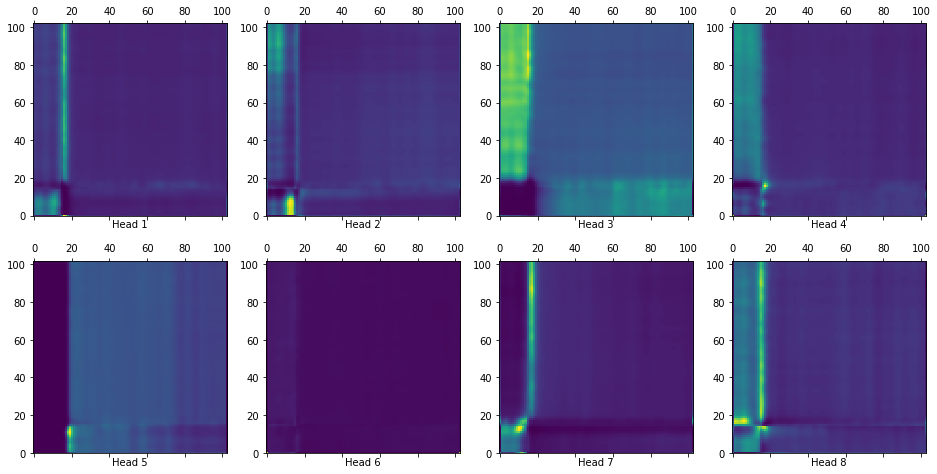

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[-1.        ],
        [ 1.3228816 ],
        [ 0.37219262],
        [ 0.17691334],
        [-2.0901866 ]]], dtype=float32)>

In [1078]:
translate(x_test,plot_encoder= 'encoder_layer2',plot_decoder = 'decoder_layer2_block1')

C:\Users\roberthaase\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


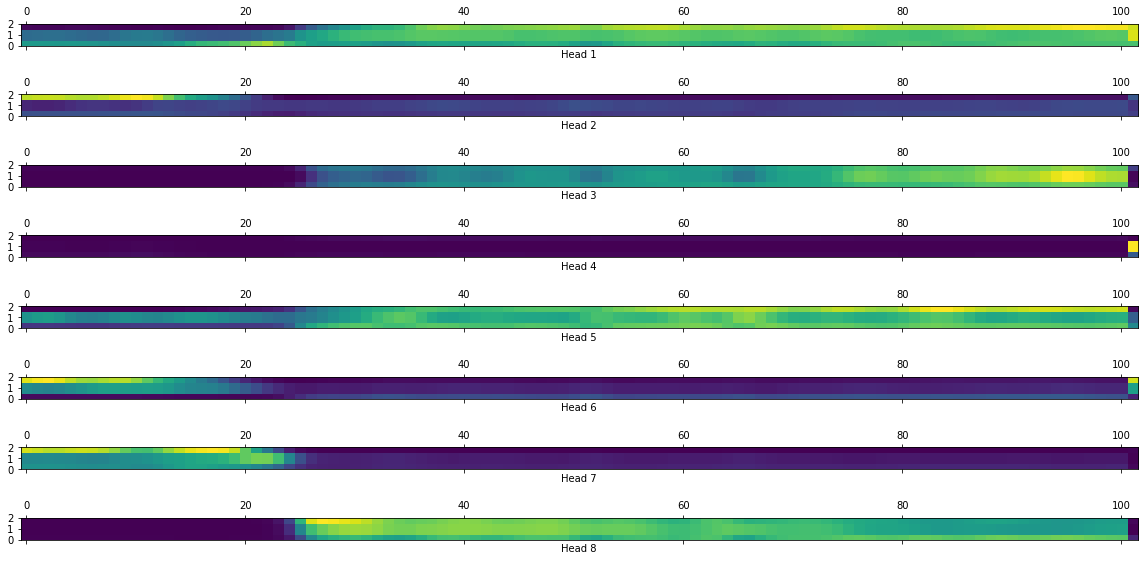

In [1076]:
example_decoder = tf.squeeze(attention['decoder_layer2_block2'],axis = 0)

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(8,1,1)
ax.matshow(example_decoder[4],cmap = 'viridis')
dim_attention = example_decoder.shape[1]
for head in range(example_decoder.shape[0]):
    ax = fig.add_subplot(8, 1, head+1)
    #print(example_decoder[head][:-1,1:].shape)
    # plot the attention weights
    ax.matshow(example_decoder[head][:-1,1:], cmap='viridis')
    ax.invert_yaxis()
    fontdict = {'fontsize': 10}

    #ax.set_xticks(range(len(sentence)+2))
    #ax.set_yticks(range(len(result)))

    ax.set_ylim(0, dim_attention - 2)

    #ax.set_xticklabels('{}'.format(sentence),fontdict = fontdict, rotation=90)

    #ax.set_yticklabels('{}'.format(result),fontdict = fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

plt.tight_layout()
plt.show()

(1, 103, 4) (1, 5, 1)


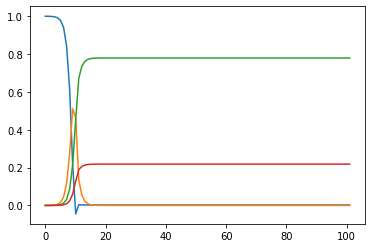

<Figure size 720x720 with 0 Axes>

In [1286]:
dic_eval = data_generator(1,t_obs= 100,to_tensor= True)
theta_eval = dic_eval['theta']
x_eval = dic_eval['x']
x_test = np.array(x_eval)
x_test = np.insert(x_test,0,-1,axis = 1)
x_test = np.insert(x_test,102,-2,axis = 1)

y_test = np.array(theta_eval)
y_test = np.insert(y_test,0,-1,axis = 1)
y_test = np.insert(y_test,4,-2,axis = 1)
y_test = np.expand_dims(y_test,-1)

print(x_test.shape,y_test.shape)

time_example = np.linspace(0,x_eval[0].shape[0],x_eval[0].shape[0])
for i in range(int(x_eval[0].shape[1])):
    plt.plot(time_example,x_eval[0,:,i])
plt.figure(figsize=(10,10))
plt.show()

In [1287]:
y_test

array([[[-1.        ],
        [ 2.3691947 ],
        [ 0.46940538],
        [ 0.13157493],
        [-2.        ]]], dtype=float32)

In [1288]:
pred,_,_ = evaluate(x_test)
pred

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[-1.        ],
        [ 2.3613572 ],
        [ 0.46710312],
        [ 0.13622236],
        [-2.0897498 ]]], dtype=float32)>

In [1289]:
alpha_test = y_test[0,1,0]
beta_test = y_test[0,2,0]
gamma_test = y_test[0,3,0]

In [1290]:
N = 10000
dt = 1.
S0 = 1 - 1/N
I0 = 1/N
D0 = 0
R0 = 0

S_test,I_test,R_test,D_test = [S0],[I0],[D0],[R0]
t = np.linspace(0, 100, int(100/dt) + 1)
for _ in enumerate(t[1:]):

    next_S = S_test[-1] + (-alpha_test*S_test[-1]*I_test[-1])*dt
    next_I = I_test[-1] + (alpha_test*S_test[-1]*I_test[-1] - beta_test*I_test[-1] - gamma_test*I_test[-1])*dt
    next_R = R_test[-1] + (beta_test*I_test[-1])*dt
    next_D = D_test[-1] + (gamma_test*I_test[-1])*dt

    S_test.append(next_S)
    I_test.append(next_I)
    D_test.append(next_D)
    R_test.append(next_R)

In [1291]:
alpha = pred[0,1,0]
beta  = pred[0,2,0]
gamma = pred[0,3,0]

In [1292]:
N = 10000
dt = 1.
S0 = 1 - 1/N
I0 = 1/N
D0 = 0
R0 = 0

S,I,R,D = [S0],[I0],[D0],[R0]
t = np.linspace(0, 100, int(100/dt) + 1)
for _ in enumerate(t[1:]):

    next_S = S[-1] + (-alpha*S[-1]*I[-1])*dt
    next_I = I[-1] + (alpha*S[-1]*I[-1] - beta*I[-1] - gamma*I[-1])*dt
    next_R = R[-1] + (beta*I[-1])*dt
    next_D = D[-1] + (gamma*I[-1])*dt

    S.append(next_S)
    I.append(next_I)
    D.append(next_D)
    R.append(next_R)

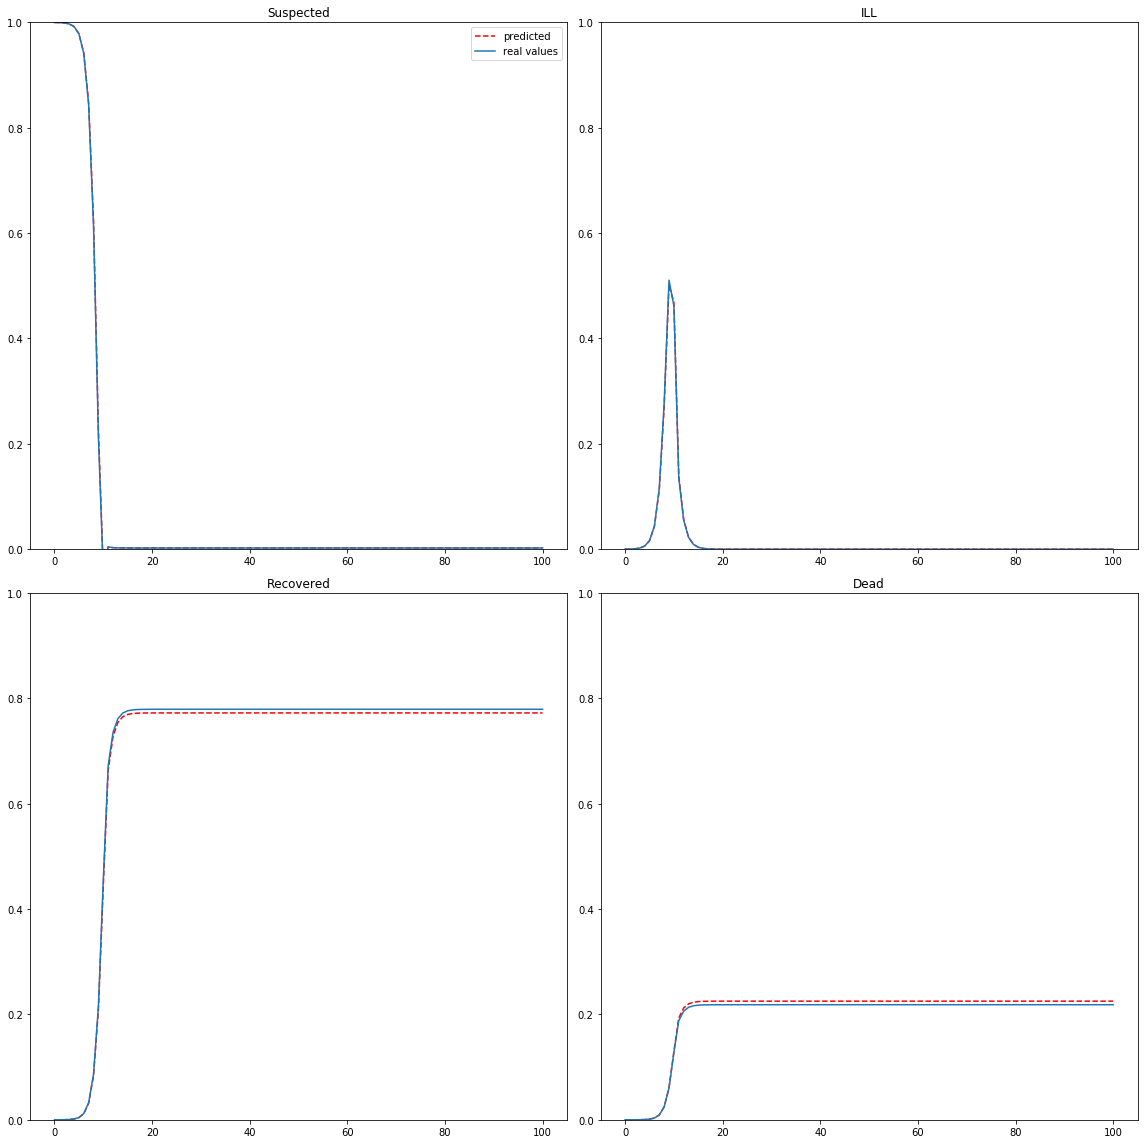

In [1293]:
fig = plt.figure(figsize = (16,16))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t,S,linestyle = '--',c = 'r',label = 'predicted')
#ax1.set_dashes([2, 2, 10, 2]) 
ax1.plot(t,S_test,label = 'real values')
ax1.title.set_text('Suspected')
ax1.legend()
ax1.set_ylim(0,1)

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(t,I,linestyle = '--',c = 'r')
ax2.plot(t,I_test)
ax2.title.set_text('ILL')
ax2.set_ylim(0,1)


ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(t,R,linestyle = '--',c = 'r')
ax3.plot(t,R_test)
ax3.title.set_text('Recovered')
ax3.set_ylim(0,1)

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(t,D,linestyle = '--',c = 'r')
ax4.plot(t,D_test)
ax4.title.set_text('Dead')
ax4.set_ylim(0,1)

#ax.set_xticks(range(len(sentence)+2))
#ax.set_yticks(range(len(result)))

#ax.set_ylim(0, dim_attention - 2)

#ax.set_xticklabels('{}'.format(sentence),fontdict = fontdict, rotation=90)

#ax.set_yticklabels('{}'.format(result),fontdict = fontdict)

#ax.set_xlabel('Head {}'.format(head+1))

plt.tight_layout()
plt.show()

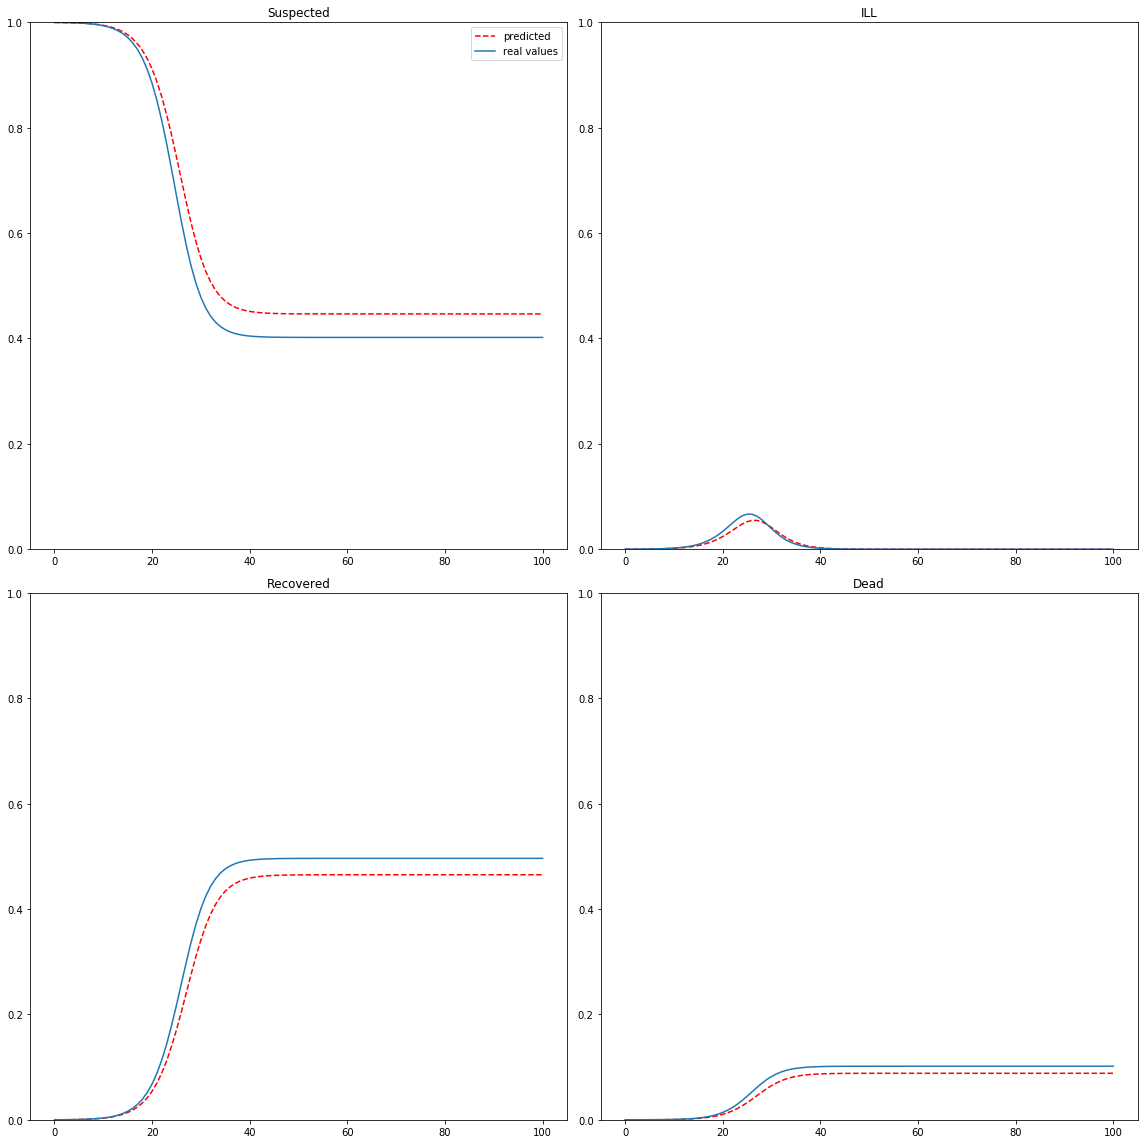

In [1283]:
fig = plt.figure(figsize = (16,16))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t,S,linestyle = '--',c = 'r',label = 'predicted')
#ax1.set_dashes([2, 2, 10, 2]) 
ax1.plot(t,S_test,label = 'real values')
ax1.title.set_text('Suspected')
ax1.legend()
ax1.set_ylim(0,1)

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(t,I,linestyle = '--',c = 'r')
ax2.plot(t,I_test)
ax2.title.set_text('ILL')
ax2.set_ylim(0,1)


ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(t,R,linestyle = '--',c = 'r')
ax3.plot(t,R_test)
ax3.title.set_text('Recovered')
ax3.set_ylim(0,1)

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(t,D,linestyle = '--',c = 'r')
ax4.plot(t,D_test)
ax4.title.set_text('Dead')
ax4.set_ylim(0,1)

#ax.set_xticks(range(len(sentence)+2))
#ax.set_yticks(range(len(result)))

#ax.set_ylim(0, dim_attention - 2)

#ax.set_xticklabels('{}'.format(sentence),fontdict = fontdict, rotation=90)

#ax.set_yticklabels('{}'.format(result),fontdict = fontdict)

#ax.set_xlabel('Head {}'.format(head+1))

plt.tight_layout()
plt.show()

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.